In [1]:
import wfdb
import numpy as np
import os

# Path to the folder containing the records
folder_path = 'C:\\Users\\jacob\\Desktop\\GitHub\\CS593-ProjectFiles\\Project 3\\ECG Anomoly Detection\\Dataset'

# List of record names
records = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.dat')]

# Initialize empty lists to store the data
data = []
labels = []

# Window size
window_size = 3600

# Loop over all records
for record_name in records:
    try:
        # Load the record and the annotations
        record = wfdb.rdrecord(os.path.join(folder_path, record_name))
        annotation = wfdb.rdann(os.path.join(folder_path, record_name), 'atr')

        # Filter out spikes that are 3 standard deviations from the mean
        signal_mean = np.mean(record.p_signal, axis=0)
        signal_std = np.std(record.p_signal, axis=0)
        mask = np.abs(record.p_signal - signal_mean) <= 3*signal_std
        record.p_signal = np.where(mask, record.p_signal, signal_mean)
        
        # Pad the signal data with zeros until its length is a multiple of the window size
        padded_length = np.ceil(record.p_signal.shape[0] / window_size) * window_size
        padded_signal = np.pad(record.p_signal, ((0, int(padded_length - record.p_signal.shape[0])), (0, 0)))

        # Reshape the padded signal data into windows
        X = np.reshape(padded_signal, (-1, window_size, 2))

        # Create labels for each window based on the annotations
        Y = np.zeros(X.shape[0])
        for i in range(len(annotation.sample)):
            if annotation.symbol[i] != 'N':
                Y[annotation.sample[i] // window_size] = 1

        # Append the data and the labels to the lists
        data.append(X)
        labels.append(Y)
    except:
        print(f"Error loading record {record_name}")

# Concatenate all the data and labels
data = np.concatenate(data)
labels = np.concatenate(labels)

# Robust data Standardization: Usiong median and interquartile range

I suspect there are outliers in some of the data, so we will switch to using the median and interquartile range. This makes our standardization more robust to outliers.

In [2]:
median = np.median(data, axis=(0, 1))
iqr = np.subtract(*np.percentile(data, [75, 25], axis=(0, 1)))

# Standardize the data using the robust estimates
data = (data - median) / iqr

# Split the data

In [3]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

# Further split the training set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


# Set Up The Model


In [4]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers

# Initialize the model
model = Sequential()

# Add the first convolutional layer with L2 regularization
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(window_size, 2)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another convolutional layer with L2 regularization
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add another max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of the previous layer
model.add(Flatten())

# Add a dense layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3596, 64)          704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1798, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1794, 128)         41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 897, 128)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 114816)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [5]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 4s 13ms/step - loss: 1.5345 - accuracy: 0.6974 - val_loss: 0.8712 - val_accuracy: 0.7313
Epoch 2/10
163/163 [==============================] - 2s 12ms/step - loss: 0.7735 - accuracy: 0.7404 - val_loss: 0.6862 - val_accuracy: 0.7491
Epoch 3/10
163/163 [==============================] - 2s 11ms/step - loss: 0.6752 - accuracy: 0.7502 - val_loss: 0.7096 - val_accuracy: 0.7365
Epoch 4/10
163/163 [==============================] - 2s 12ms/step - loss: 0.6389 - accuracy: 0.7483 - val_loss: 0.6056 - val_accuracy: 0.7480
Epoch 5/10
163/163 [==============================] - 2s 11ms/step - loss: 0.6173 - accuracy: 0.7423 - val_loss: 0.5914 - val_accuracy: 0.7618
Epoch 6/10
163/163 [==============================] - 2s 11ms/step - loss: 0.6004 - accuracy: 0.7508 - val_loss: 0.5978 - val_accuracy: 0.7486
Epoch 7/10
163/163 [==============================] - 2s 11ms/step - loss: 0.6017 - accuracy: 0.7513 - val_loss: 0.5848 - val_accuracy: 0.7578

In [6]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.3f' % accuracy)

55/55 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.7560
Test Accuracy: 0.756


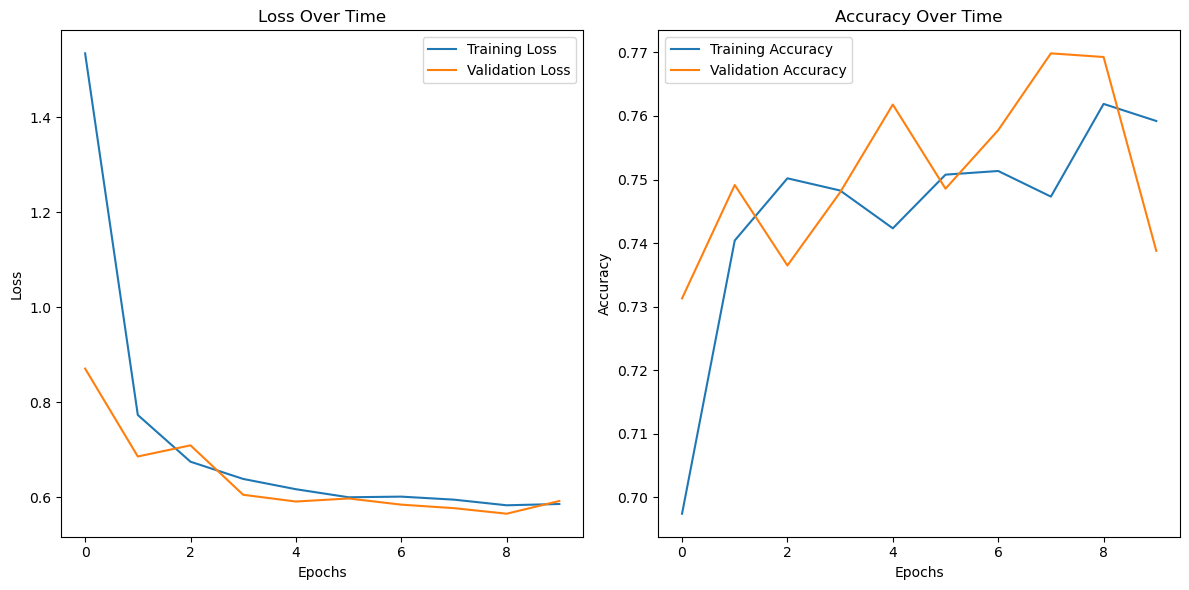

In [7]:
import matplotlib.pyplot as plt

# Plot the training loss and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 23ms/step


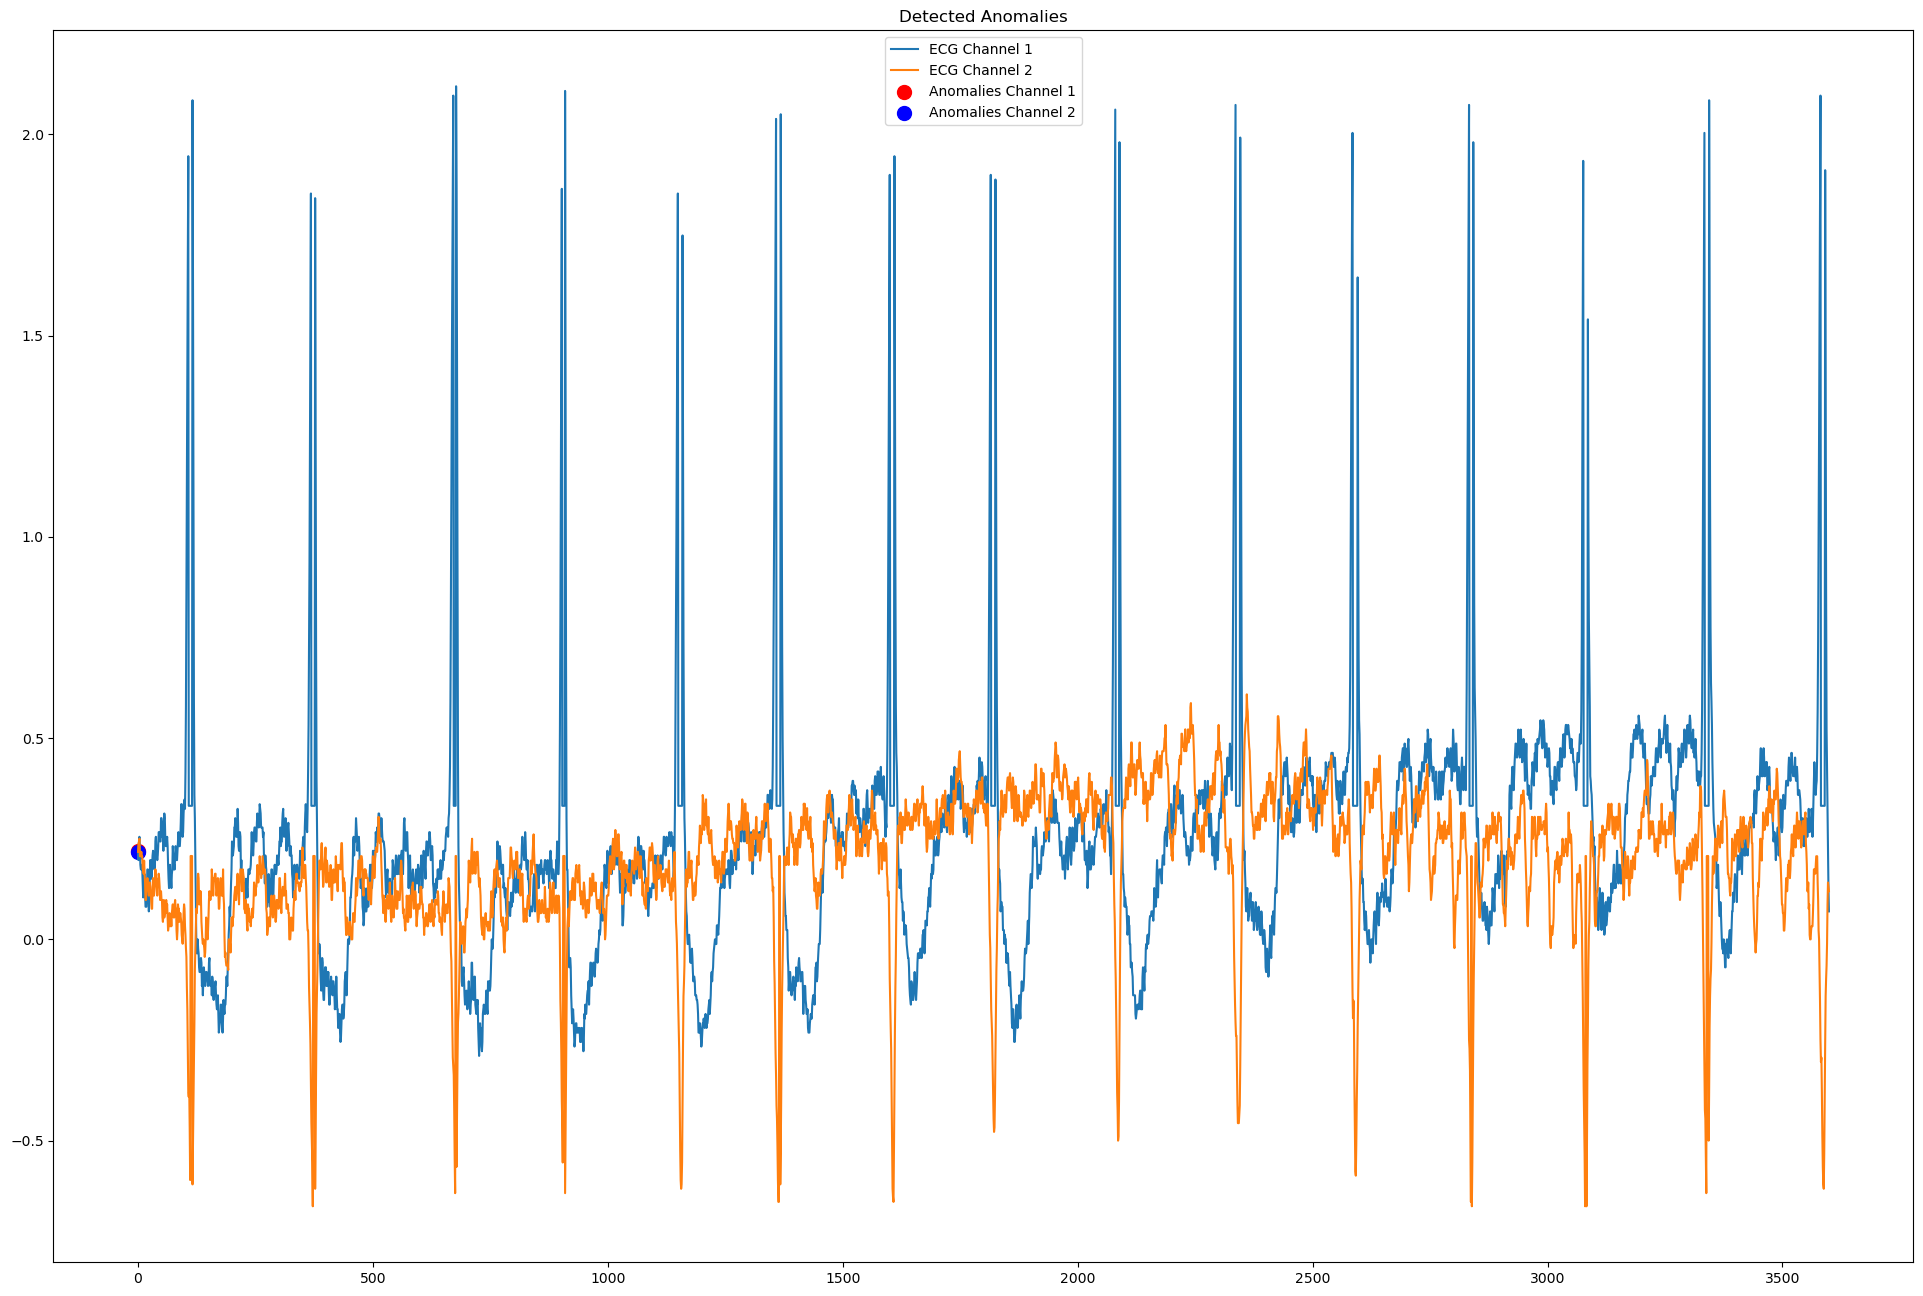

In [12]:
import matplotlib.pyplot as plt

# Select one example from the test set
example = X_test[0]

# Reshape the example to a batch of size 1
example = example.reshape(1, window_size, 2)

# Perform a prediction on the example
prediction = model.predict(example)

# Calculate the anomaly scores (distance from 0.5)
scores = np.abs(prediction - 0.5)

# Find the indices of the anomalies
anomaly_indices = np.where(scores > 0.1)[1]

# Plot the ECG signals
plt.figure(figsize=(24, 16))
plt.plot(example[0, :, 0], label='ECG Channel 1')
plt.plot(example[0, :, 1], label='ECG Channel 2')

# Check if there are any anomalies
if anomaly_indices.size > 0:
    # Overlay the anomalies with larger, red dots
    plt.scatter(anomaly_indices, example[0, anomaly_indices, 0], color='red', s=100, label='Anomalies Channel 1')
    plt.scatter(anomaly_indices, example[0, anomaly_indices, 1], color='blue', s=100, label='Anomalies Channel 2')
else:
    print("No anomalies detected")

plt.title('Detected Anomalies')
plt.legend()
plt.show()
